In [ ]:
import os, sys, pyabf, scipy, json, skimage, copy, tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation, feature
from scipy import ndimage as ndi
from pathlib import Path
from roifile import ImagejRoi
from read_roi import read_roi_file
from skimage.draw import polygon
from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import zscore
#from voltage_imaging_utils import load_video, detrend_signal, compute_dff, plot_traces, segment_cells, extract_traces, plot_cell_traces

### LOAD AND PREPROCESS FUN

In [52]:
def load_all_tiffs_from_day(base_day_folder, visualize_unexpected=True):
    """
    Loads all TIFF files recursively from a day folder.
    Expected structure:
        day_folder/cell_number/protocol_type/file_folder/file.tif
    Returns a dictionary organized as:
        data_dict[cell][protocol][trial_name] = numpy array
    """
    data_dict = {}
    sd70_path = None
    unexpected_files = []
    
    for root, dirs, files in os.walk(base_day_folder):
        # --- Skip folders containing 'population' in their path ---
        if "population" in root.lower():
            print(f"⏭️  Skipping folder (population): {root}")
            # Optional: clear dirs to prevent descending further
            dirs[:] = []
            continue
        
        for f in files:
            if f.lower().endswith(('.tif', '.tiff')):
                full_path = os.path.join(root, f)
                # Split path components to extract hierarchy
                rel_path = os.path.relpath(full_path, base_day_folder)
                parts = rel_path.split(os.sep)

                # Expect at least 4 levels: cell / protocol / trial_folder / file
                #if len(parts) < 4:
                #    print(f"⚠️ Skipping {full_path}, unexpected structure.")
                #    continue

                cell, protocol, trial_folder = parts[0], parts[1], parts[2]

                # Initialize nested dicts
                data_dict.setdefault(cell, {})
                data_dict[cell].setdefault(protocol, {})
                
                if "sd70-10" in root.lower():
                    sd70_path = full_path

                data_dict[cell][protocol][trial_folder] = tifffile.imread(full_path)

                # Load TIFF file
                print(f"📂 Loading: {cell} | {protocol} | {trial_folder} | {f}")
                data = tifffile.imread(full_path)

                # Store under structured key
                data_dict[cell][protocol][trial_folder] = data
                
    if visualize_unexpected and unexpected_files and len(parts) < 4:
        print(f"\n🧩 Visualizing {len(unexpected_files)} unexpected TIFF(s)...")
        for path in unexpected_files:
            try:
                data = tifffile.imread(path)
                #plt.figure(figsize=(5, 5))
                if data.ndim == 3:  # assume (frames, y, x)
                    mean_img = np.mean(data, axis=0)
                    #plt.imshow(mean_img, cmap='gray')
                    plt.title(f"Unexpected: {os.path.basename(path)} (mean projection)")
                elif data.ndim == 2:
                    #plt.imshow(data, cmap='gray')
                    plt.title(f"Unexpected: {os.path.basename(path)}")
                else:
                    print(f"⚠️ Unknown data shape for {path}: {data.shape}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"❌ Error loading {path}: {e}")


    return data_dict, unexpected_files

def find_roi_source_folders(base_day_folder):
    roi_candidates = {}

    for cell_folder in [os.path.join(base_day_folder, d) for d in os.listdir(base_day_folder) if os.path.isdir(os.path.join(base_day_folder, d))]:
        protocol_folders = [os.path.join(cell_folder, d) for d in os.listdir(cell_folder)
                            if os.path.isdir(os.path.join(cell_folder, d)) and "population" not in d.lower()]

        # Try to find SD or sensitivity folder
        sd_folder = next((p for p in protocol_folders if "spike" in os.path.basename(p).lower()), None)
        sens_folder = next((p for p in protocol_folders if "sens" in os.path.basename(p).lower()), None)

        roi_folder = sd_folder if sd_folder else sens_folder
        if roi_folder:
            roi_candidates[cell_folder] = roi_folder
            
    save_path = os.path.join(base_day_folder, "roi_sources.json")

    return roi_candidates

def load_roi_sources_json(base_dir):
    save_path = os.path.join(base_dir, "roi_sources.json")
    with open(save_path, "w") as f:
        json.dump(roi_sources, f, indent=2)
    print(f"✅ Saved all ROI sources in {save_path}")
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            return json.load(f)
    else:
        print("⚠️ No roi_sources.json found.")
        return {}

def calculate_spatial_average(data, dim_spatial_average_kernel_pix=3, disp_fig=False):
    data[np.isnan(data)] = np.nanmean(data)
    
    spatial_average_kernel = np.ones([dim_spatial_average_kernel_pix, dim_spatial_average_kernel_pix])
    cent_pix = np.ceil(np.divide(dim_spatial_average_kernel_pix - 1, 2)).astype(int)
    spatial_average_kernel[cent_pix, cent_pix] = 0

    if len(data.shape) > 2:
        spatial_average = np.mean([scipy.ndimage.convolve(_, spatial_average_kernel, origin=0) for _ in data], axis=0)
        norm = np.mean([scipy.ndimage.convolve(_, spatial_average_kernel, origin=0) for _ in np.ones_like(data)], axis=0)
        
    else:
        spatial_average = scipy.ndimage.convolve(data, spatial_average_kernel, origin=0)
        norm = scipy.ndimage.convolve(np.ones_like(data), spatial_average_kernel, origin=0)

    spatial_average = spatial_average/norm

    if disp_fig:
        fig, ax = plt.subplots()
        ax.imshow(spatial_average)
        plt.show()

    return spatial_average

def generate_segmentation_masks(img_to_segment, approx_radius_scanless_excitation_spot, disp_img=False):

    threshold_value = skimage.filters.threshold_otsu(img_to_segment)
    init_segmentation = np.ones_like(img_to_segment)
    init_segmentation[img_to_segment < threshold_value] = 0

    # keep largest segment
    labels = skimage.measure.label(init_segmentation, return_num=False)
    init_segmentation = labels == np.argmax(np.bincount(labels.flat, weights=init_segmentation.flat))
    
    tmp = skimage.morphology.disk(radius=approx_radius_scanless_excitation_spot/2)

    dilated_segmentation = skimage.morphology.dilation(init_segmentation, tmp)

    anti_cell_mask = copy.deepcopy(dilated_segmentation)
    anti_cell_mask = scipy.ndimage.binary_fill_holes(anti_cell_mask).astype(np.float64)
    anti_cell_mask = np.abs(anti_cell_mask - 1).astype(np.float64)

    if np.sum(anti_cell_mask) == 0: 
        anti_cell_mask[0,0] = 1
        anti_cell_mask[0,-1] = 1
        anti_cell_mask[-1,0] = 1
        anti_cell_mask[-1,-1] = 1

    if disp_img is True:      
        fig, axs = plt.subplots(nrows=1, ncols=4)
        # fig.set_size_inches(12,4)
        ax0, ax1, ax2, ax3 = axs
        ax0.imshow(img_to_segment)
        ax0.set_title("To segment")
        ax1.imshow(init_segmentation*img_to_segment)
        ax1.set_title("Initial segmentation")
        ax2.imshow(dilated_segmentation*img_to_segment)
        ax2.set_title("Dilated segmentation")
        ax3.imshow(anti_cell_mask*img_to_segment)
        ax3.set_title("Anti-cell mask")
        [ax.axis("off") for ax in axs]
        # fig.suptitle("Segmentation")
        plt.tight_layout()
        plt.show()

    return init_segmentation, dilated_segmentation, anti_cell_mask

def create_masks_from_sd_recording(sd_tiff, approx_radius_scanless_excitation_spot=15,
                                   spatial_kernel_pix=15, dff_percentile=90,
                                   disp_img=True):
    """
    Generate segmentation masks from SD70-10-1s recording:
    - Computes spatially averaged image
    - Computes ΔF/F activity map
    - Combines both for robust segmentation
    - Returns ROI (cell) and anti-ROI (background) masks
    """

    # Step 1. Replace NaNs
    data = sd_tiff.astype(float)
    data[np.isnan(data)] = np.nanmean(data)
        # Step 2. Compute spatial average (smoothing)
    spatial_average = calculate_spatial_average(data, dim_spatial_average_kernel_pix=spatial_kernel_pix, disp_fig=False)

    # Step 3. Compute ΔF/F per pixel
    f0 = np.percentile(data, 10, axis=0)  # baseline (10th percentile)
    fmax = np.percentile(data, dff_percentile, axis=0)
    dff = (fmax - f0) / np.maximum(f0, 1e-6)

    # Step 4. Normalize maps and combine them
    spatial_norm = (spatial_average - np.min(spatial_average)) / (np.max(spatial_average) - np.min(spatial_average))
    dff_norm = (dff - np.min(dff)) / (np.max(dff) - np.min(dff))
    combined_img = 0.5 * spatial_norm + 0.5 * dff_norm

    # Step 5. Use your segmentation function on the combined image
    init_segmentation, dilated_segmentation, anti_cell_mask = generate_segmentation_masks(
        combined_img,
        approx_radius_scanless_excitation_spot=approx_radius_scanless_excitation_spot,
        disp_img=disp_img
    )

    return init_segmentation, dilated_segmentation, anti_cell_mask, combined_img

def load_video(cell_folder):
    cell_folder = str(cell_folder)  # ✅ ensure it's a string
    print("Loading video from:", cell_folder)

    ext = os.path.splitext(cell_folder)[1].lower()
    if ext == '.roi':
        roi_path = os.path.join(cell_folder, 'roi_mask.roi')
        roi = ImagejRoi.fromfile(roi_path)
        mask = roi.to_mask(shape=(cell_folder.shape[1], cell_folder.shape[2]))
        return mask
    elif ext == '.npy':
        return np.load(cell_folder, allow_pickle=True)    
    elif ext in ['.tif', '.tiff']:
        return tifffile.imread(cell_folder)
    else:
        raise ValueError(f"Unsupported video format: {ext}")
    
def load_roi_mask(roi_path, shape):
    roi_dict = read_roi_file(roi_path)
    mask = np.zeros(shape, dtype=bool)

    for name, roi in roi_dict.items():
        if 'x' in roi and 'y' in roi:
            # Polygon or freehand ROI
            rr, cc = polygon(roi['y'], roi['x'], shape)
            mask[rr, cc] = True

        elif all(k in roi for k in ('left', 'top', 'width', 'height')):
            # Rectangle or oval ROI
            x0, y0 = roi['left'], roi['top']
            x1, y1 = x0 + roi['width'], y0 + roi['height']
            mask[y0:y1, x0:x1] = True

        else:
            print(f"⚠️ Unknown ROI type for '{name}', keys: {list(roi.keys())}")
    return mask

def extract_trace(video_path):
    video_stack = load_video(video_path)
    mask = load_roi_mask(os.path.join(cell_folder, 'roi_mask1.roi'), video_stack.shape[1:]).astype(bool)

    # Ensure dimensions match
    if mask.shape != video_stack.shape[1:]:
        raise ValueError(f"Mask shape {mask.shape} does not match video frames {video_stack.shape[1:]}")

    masked_pixels = video_stack * mask
    trace = masked_pixels.sum(axis=(1,2)) / mask.sum()
    print("Loaded video:", video_stack.shape)
    print("Loaded mask:", mask.shape)
    return trace

def detect_epochs_and_average(trace, n_epochs=50, light_on_off_buffer_nframes=5, skip_first=1):
    """Find repeated epochs based on signal changes, align, and average."""
    estimated_epochs, _ = scipy.signal.find_peaks(np.abs(np.diff(trace)))
    # pick the 2*n_epochs largest transitions (start/end of epochs)
    estimated_epochs = np.sort(
        estimated_epochs[np.argsort(np.abs(np.diff(trace))[estimated_epochs])[::-1][:2 * n_epochs]]
    )

    # estimate epoch duration
    est_epoch_duration = []
    for idxs in estimated_epochs.reshape(n_epochs, -1):
        est_epoch_duration.append(idxs[-1] - idxs[0])
    est_epoch_duration = int(np.floor(np.mean(est_epoch_duration)))

    # collect per-epoch segments around stimulation
    idxs_laser_on = []
    for idxs in estimated_epochs.reshape(n_epochs, -1):
        start = idxs[0] + light_on_off_buffer_nframes
        end = idxs[0] + est_epoch_duration - light_on_off_buffer_nframes + 1

        # ✅ clip or skip if it exceeds trace length
        if end > len(trace):
            print(f"⚠️ Skipping truncated epoch (end={end}, len={len(trace)})")
            continue

        idxs_laser_on.append(np.arange(start, end))

    # flatten and gather epochs - skip first epoch(s)
    if len(idxs_laser_on) <= skip_first:
        print("⚠️ Not enough valid epochs after skipping, returning None.")
        return None, []

    all_epochs = [trace[idxs] for idxs in idxs_laser_on[skip_first:]]
    mean_epoch = np.mean(np.vstack(all_epochs), axis=0)
    return mean_epoch, all_epochs

def exp_model(p, t):
    """Exponential model: a * exp(-t/tau) + b"""
    a, tau, b = p
    return a * np.exp(-t / tau) + b

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

def detrend_trace(y, t, detrend_method="linear", mask_range=(180, 400),
                  smooth_window=5, exp_init_tau_seconds=0.3, fs=10, exp_robust=False):
    """
    Detrend one trace with 'smooth', 'exp', or 'linear' methods.
    """
    y_temp = y.copy().astype(float)
    y_temp[mask_range[0]:mask_range[1]] = np.nan  # mask unwanted region

    if detrend_method == "smooth":
        ybase = uniform_filter1d(np.nan_to_num(y_temp, nan=np.nanmean(y_temp)), size=smooth_window)

    elif detrend_method == "exp":
        # Initial guesses
        a0 = np.nanmax(y_temp) - np.nanmin(y_temp)
        tau0 = max(1 / fs, exp_init_tau_seconds)
        b0 = np.nanmedian(y_temp)
        p0 = np.array([a0, tau0, b0])

        # Cost function
        def tukey_weights(resid, c=4.685):
            r = resid / np.nanstd(resid)
            w = np.ones_like(r)
            mask = np.abs(r) > c
            w[mask] = (1 - (r[mask] / c) ** 2) ** 2
            w[np.abs(r) > c] = 0
            return w

        def cost(p):
            resid = y_temp - exp_model(p, t)
            if exp_robust:
                w = tukey_weights(resid)
                return np.nansum(w * resid**2)
            else:
                return np.nansum(resid**2)

        res = minimize(cost, p0, method="Nelder-Mead", options=dict(maxiter=5e4, xatol=1e-8, fatol=1e-8))
        p = res.x
        p[1] = max(p[1], 1 / fs)
        ybase = exp_model(p, t)

    elif detrend_method == "linear":
        idx = ~np.isnan(y_temp)
        if np.sum(idx) < 2:
            ybase = np.full_like(y, np.nanmedian(y_temp))
        else:
            pp = np.polyfit(t[idx], y_temp[idx], 1)
            ybase = np.polyval(pp, t)
    else:
        raise ValueError(f"Unknown detrend method: {detrend_method}")

    yd = y - ybase + np.nanmean(ybase)
    return yd, ybase

def safe_mask(mask, n_time):
    """
    Clip mask indices to valid range (0..n_time-1).
    Ensures no IndexError even if mask goes out of bounds.
    """
    mask = np.array(mask, dtype=int)
    return mask[(mask >= 0) & (mask < n_time)]

def compute_metrics(Yd, baseline_mask, mean_mask, offset_camera=100):
    n_time, n_traces = Yd.shape
    
    baseline_mask = safe_mask(baseline_mask, n_time)
    mean_mask = safe_mask(mean_mask, n_time)
        
    baseline_mean = np.nanmean(Yd[baseline_mask, :], axis=0)
    baseline_std = np.nanstd(Yd[baseline_mask, :], axis=0)
    mean_value = np.nanmean(Yd[mean_mask, :], axis=0) 

    signal = (mean_value - baseline_mean) - offset_camera
    noise = baseline_std
    baseline_camera_corr = baseline_mean - offset_camera
    dff = signal / baseline_camera_corr
    snr = np.abs(signal / noise)

    return dict(
        Signal=signal,
        Noise=noise,
        Baseline_Cameracorr=baseline_camera_corr,
        dFF=dff,
        SNR=snr
    )

def detrend_and_analyze(Y, t, fs, detrend_method="linear", baseline_mask=None, mean_mask=None,
                        exp_init_tau_seconds=0.3, exp_robust=False, smooth_window=5, index_test_trace=None):
    """
    Detrend all traces and compute metrics.
    Y: 2D array (time x traces)
    """
    n_time, n_traces = Y.shape
    Yd = np.zeros_like(Y)
    baselineFits = np.zeros_like(Y)

    for k in range(n_traces):
        y = Y[:, k]
        yd, ybase = detrend_trace(
            y, t, detrend_method=detrend_method,
            exp_init_tau_seconds=exp_init_tau_seconds,
            fs=fs, exp_robust=exp_robust,
            smooth_window=smooth_window
        )

        Yd[:, k] = yd
        baselineFits[:, k] = ybase

        if index_test_trace is not None and k == index_test_trace:
            plt.figure(figsize=(6, 4))
            plt.plot(t, y, 'b', label='Raw')
            plt.plot(t, ybase, 'g', label=f'{detrend_method} fit')
            plt.plot(t, yd, 'r', label='Detrended')
            plt.xlabel("Time (s)")
            plt.ylabel("Signal (a.u.)")
            plt.legend()
            plt.title(f"Trace {k+1} — {detrend_method} detrend")
            plt.grid(True)
            plt.show()

    metrics = compute_metrics(Yd, baseline_mask, mean_mask)
    return Yd, baselineFits, metrics

def plot_metrics(metrics):
    x = np.arange(1, len(metrics["Signal"]) + 1)

    plt.figure(figsize=(7, 9))
    plt.subplot(3, 1, 1)
    plt.title("Signal / Noise / Camera-corrected Baseline")
    plt.scatter(x, metrics["Signal"], label="Signal")
    plt.scatter(x, metrics["Noise"], label="Noise")
    #plt.scatter(x, metrics["Baseline_Cameracorr"], label="BaselineCameraCorr")
    plt.plot(x, metrics["Signal"])
    plt.plot(x, metrics["Noise"])
    #plt.plot(x, metrics["Baseline_Cameracorr"])
    plt.xlabel("Trace #")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.title("dF/F")
    plt.scatter(x, metrics["dFF"])
    plt.plot(x, metrics["dFF"])
    plt.xlabel("Trace #")
    plt.ylabel("dF/F")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.title("SNR")
    plt.scatter(x, metrics["SNR"])
    plt.plot(x, metrics["SNR"])
    plt.xlabel("Trace #")
    plt.ylabel("SNR")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

day_folder = r"E:\Paris2025\ForceB Undiluted\20251001"

### CORRELATION IMAGE AND Load Functions

📂 Loading: cell1 | spikeDet | 019-SD100Hz-70 | 019-SD100Hz-70_NDTiffStack.tif
📂 Loading: cell1 | spikeDet | 014-SD10hz-70 | 014-SD10hz-70_NDTiffStack.tif
📂 Loading: cell1 | spikeDet | 014-SD10hz-70 | 014-SD10hz-70_denoised_full.tif
📂 Loading: cell1 | spikeDet | 015-SD50Hz-70 | 015-SD50Hz-70_NDTiffStack.tif
📂 Loading: cell1 | spikeDet | 016-SD50Hz-70 | 016-SD50Hz-70_NDTiffStack.tif
📂 Loading: cell1 | spikeDet | 016-SD50Hz-70 | 016-SD50Hz-70_denoised_full.tif
📂 Loading: cell1 | sensitivity | 020-Sens-70 | 020-Sens-70_NDTiffStack.tif
📂 Loading: cell1 | sensitivity | 020-Sens-70 | 020-Sens-70_denoised_full.tif
📂 Loading: cell1 | subthreshold | 033-Sub6mV-70-2x2 | 033-Sub6mV-70-2x2_NDTiffStack.tif
📂 Loading: cell1 | subthreshold | 021-Sub-6mV-70-2x2 | 021-Sub-6mV-70-2x2_NDTiffStack.tif
📂 Loading: cell1 | subthreshold | 021-Sub-7mV-70-2x2 | 021-Sub-7mV-70-2x2_NDTiffStack.tif
📂 Loading: cell1 | subthreshold | 021-Sub-8mV-70-2x2 | 021-Sub-8mV-70-2x2_NDTiffStack.tif
📂 Loading: cell1 | subthresh

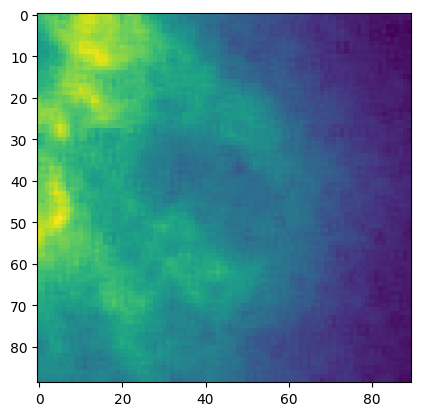

cell_folder: E:\Paris2025\ForceB Undiluted\20251001\cell1
Found 20 TIFF files for cell1


In [ ]:
data, sd70_path = load_all_tiffs_from_day(day_folder)
roi_sources = find_roi_source_folders(day_folder)
roi_sources = load_roi_sources_json(day_folder)

cell_folder, first_folder = list(roi_sources.items())[0]
first_folder = os.path.join(first_folder, '019-SD100Hz-70', '019-SD100Hz-70_NDTiffStack.tif')
expt_data = tifffile.imread(first_folder)
correlation_img = calculate_spatial_average(expt_data.astype(np.float32))

fig, ax = plt.subplots()
ax.imshow(correlation_img)
plt.show()

# labels: output of watershed (0 = background, 1,2,... = cells)
print("cell_folder:", cell_folder)

cell_folder = Path(cell_folder)  # convert to Path object
cell_videos = {f.stem: tifffile.imread(f) for f in cell_folder.rglob("*_NDTiffStack.tif")}

# ----------------------------
video_files = []
for root, dirs, files in os.walk(cell_folder):
    for file in files:
        if file.endswith(".tif") and "population" not in root.lower():
            if "roi_mask" not in file.lower():
                video_files.append(os.path.join(root, file))

print(f"Found {len(video_files)} TIFF files for {os.path.basename(cell_folder)}")

sub_files = [f for f in video_files if "Sub" in os.path.basename(os.path.dirname(f))]
sens_files = [f for f in video_files if "Sens" in os.path.basename(os.path.dirname(f))]
spike_files = [f for f in video_files if "SD" in os.path.basename(os.path.dirname(f))]

light_on_off_buffer_nframes = 10

#### Plot raw to see meanbaseline for dff

In [ ]:
# FIGURE 1: SPIKE DETECTION TRACES
print("Spike files found:", spike_files)
if spike_files:
    fig_spk, axes_spk = plt.subplots(len(spike_files), 1, figsize=(10, 3 * len(spike_files)), sharex=False)
    if len(spike_files) == 1:
        axes_spk = [axes_spk]
        
    for ax, vfile in zip(axes_spk, spike_files):
        trace = extract_trace(vfile)
        print("spike_files", vfile, "trace length:", len(trace))
        name = os.path.basename(os.path.dirname(vfile))
        ax.plot(trace, color='black', lw=0.8)
        ax.set_title(f"Spike Detection Trace: {name}")
        ax.set_ylabel("Fluorescence (a.u.)")
        ax.set_xlim(200, 300)
        ax.set_ylim(115, 130)        

    #fig_spk.suptitle("Spike Detection Files", fontsize=12, weight="bold")
    plt.tight_layout()
    plt.savefig(cell_folder / "spike_detection_traces.png", dpi=300)
    plt.show()

# FIGURE 2: SUBTHRESHOLD FILES
if sub_files:
    fig_sub, axes_sub = plt.subplots(len(sub_files), 1, figsize=(4, 6 * len(sub_files)), sharex=False)
    for ax, vfile in zip(axes_sub, sub_files):
        trace = extract_trace(vfile)
        name = os.path.basename(os.path.dirname(vfile))#.lower()
        
        n_epochs = file_to_n_epochs.get(name, 50)  # default to 50 if not in dict
        mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=n_epochs, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=1)        
        print(f"Processing: {name}")
        print(f"Expected epochs: {n_epochs}")
        print(f"Trace length: {len(trace)} frames")
        
        # Plot all epochs and mean
        for epoch in all_epochs:
            ax.plot(epoch, color='gray', alpha=0.8, lw=0.5)
        ax.plot(mean_epoch, color='magenta', lw=1, label="Mean Epoch")
        ax.legend()
        ax.set_title(f"Averaged Epochs: {os.path.basename(os.path.dirname(vfile))} ({len(all_epochs)} epochs)")
        ax.set_ylabel("Fluorescence (a.u.)")
        
    plt.tight_layout()
    plt.show()

# FIGURE 3: SENSITIVITY FILES
if sens_files:
    fig_sub, axes_sub = plt.subplots(len(sens_files), 1, figsize=(4, 6 * len(sens_files)), sharex=False)
    for ax, vfile in zip(axes_sub, sens_files):
        trace = extract_trace(vfile)
        name = os.path.basename(os.path.dirname(vfile))#.lower()
        
        n_epochs = 15  # default to 50 if not in dict
        mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=n_epochs, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=0)        
        print(f"Processing: {name}")
        print(f"Expected epochs: {n_epochs}")
        print(f"Trace length: {len(trace)} frames")
        
        # Plot all epochs and mean
        for epoch in all_epochs:
            ax.plot(epoch, color='gray', alpha=0.8, lw=0.5)
        ax.plot(mean_epoch, color='magenta', lw=1, label="Mean Epoch")
        ax.legend()
        ax.set_title(f"Averaged Epochs: {os.path.basename(os.path.dirname(vfile))} ({len(all_epochs)} epochs)")
        ax.set_ylabel("Fluorescence (a.u.)")
        
    plt.tight_layout()
    plt.show()

### Detrend & plot DF/F0
##### spike files

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\019-SD100Hz-70\019-SD100Hz-70_NDTiffStack.tif
Loaded video: (1494, 89, 90)
Loaded mask: (89, 90)


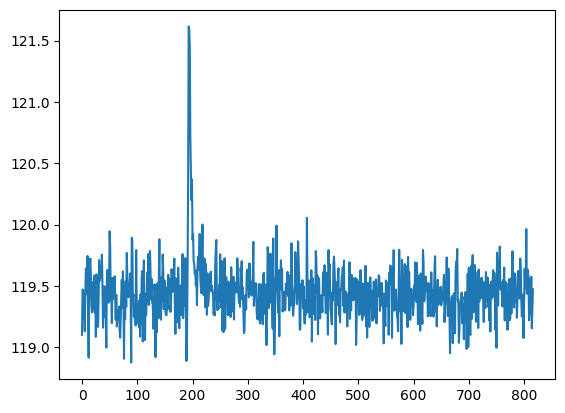

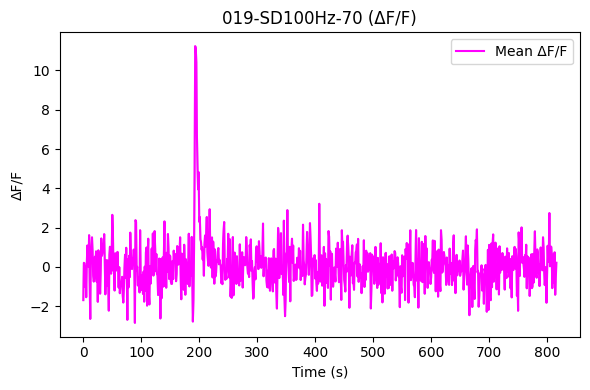

Metrics for 019-SD100Hz-70_NDTiffStack.tif
{'Signal': array([-99.9558]), 'Noise': array([0.2104]), 'Baseline_Cameracorr': array([19.4032]), 'dFF': array([-5.1515]), 'SNR': array([475.1727])}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\014-SD10hz-70\014-SD10hz-70_NDTiffStack.tif
Loaded video: (1481, 89, 90)
Loaded mask: (89, 90)


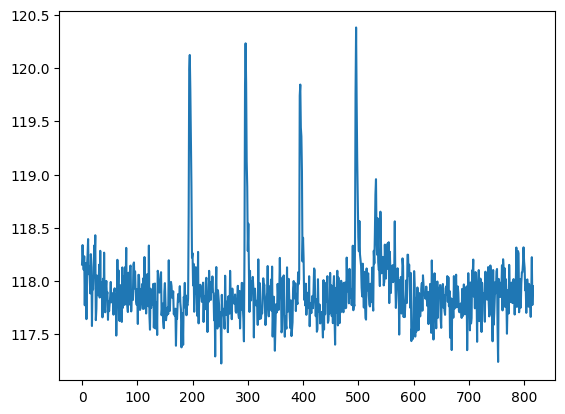

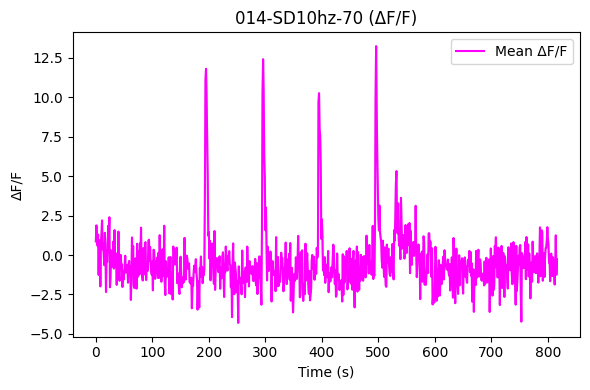

Metrics for 014-SD10hz-70_NDTiffStack.tif
{'Signal': array([-99.9823]), 'Noise': array([0.1819]), 'Baseline_Cameracorr': array([17.8463]), 'dFF': array([-5.6024]), 'SNR': array([549.5113])}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\014-SD10hz-70\014-SD10hz-70_denoised_full.tif
Loaded video: (1481, 89, 90)
Loaded mask: (89, 90)


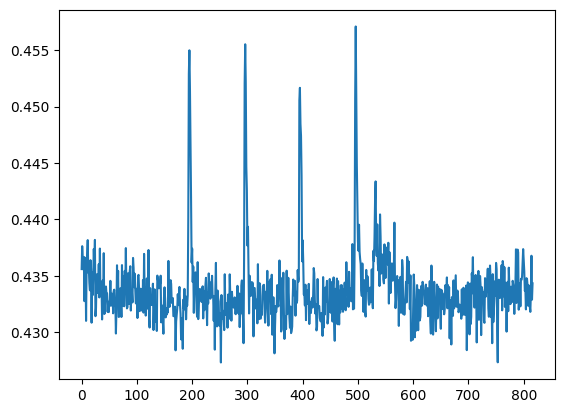

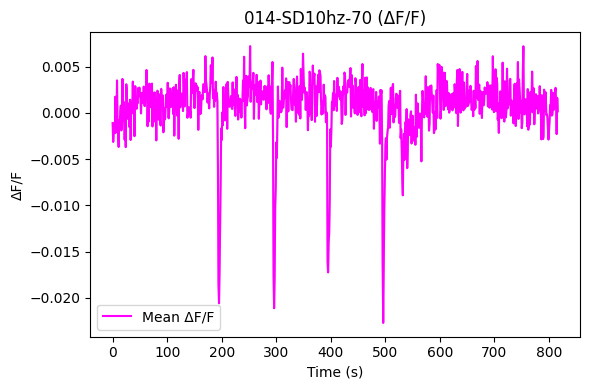

Metrics for 014-SD10hz-70_denoised_full.tif
{'Signal': array([-99.9998]), 'Noise': array([0.0017]), 'Baseline_Cameracorr': array([-99.567]), 'dFF': array([1.0043]), 'SNR': array([59893.2629])}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\015-SD50Hz-70\015-SD50Hz-70_NDTiffStack.tif
Loaded video: (1482, 89, 90)
Loaded mask: (89, 90)


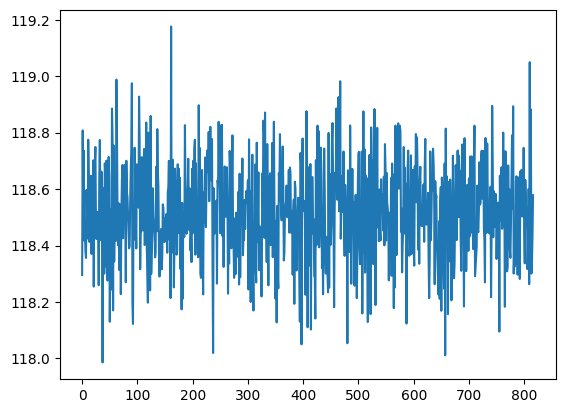

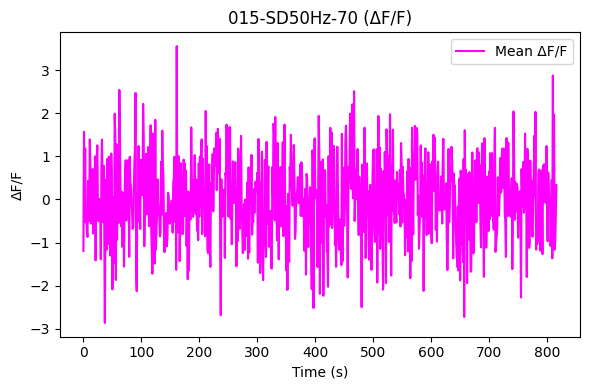

Metrics for 015-SD50Hz-70_NDTiffStack.tif
{'Signal': array([-99.9966]), 'Noise': array([0.172]), 'Baseline_Cameracorr': array([18.5129]), 'dFF': array([-5.4015]), 'SNR': array([581.2973])}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\016-SD50Hz-70\016-SD50Hz-70_NDTiffStack.tif
Loaded video: (1487, 89, 90)
Loaded mask: (89, 90)


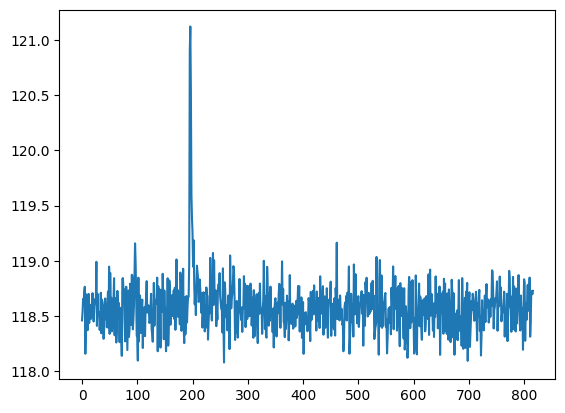

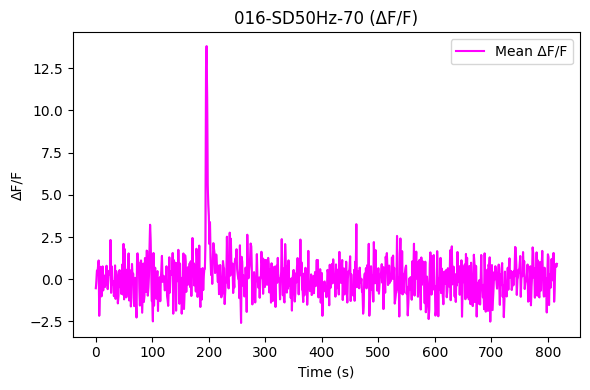

Metrics for 016-SD50Hz-70_NDTiffStack.tif
{'Signal': array([-99.9486]), 'Noise': array([0.1873]), 'Baseline_Cameracorr': array([18.5398]), 'dFF': array([-5.391]), 'SNR': array([533.4972])}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\spikeDet\016-SD50Hz-70\016-SD50Hz-70_denoised_full.tif
Loaded video: (1487, 89, 90)
Loaded mask: (89, 90)


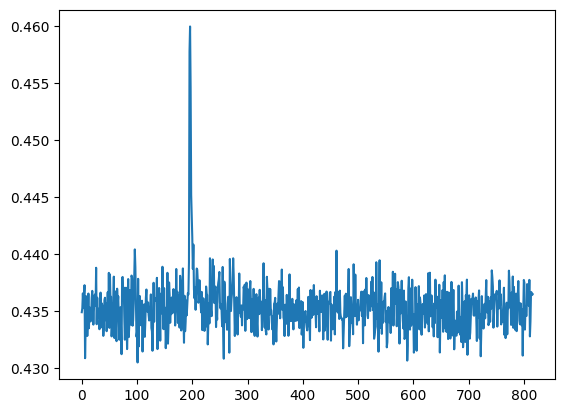

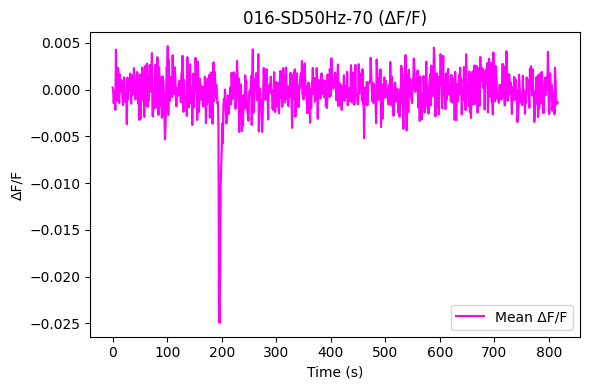

Metrics for 016-SD50Hz-70_denoised_full.tif
{'Signal': array([-99.9995]), 'Noise': array([0.0018]), 'Baseline_Cameracorr': array([-99.565]), 'dFF': array([1.0044]), 'SNR': array([55279.9254])}


In [48]:
for vfile in spike_files:
    trace = extract_trace(vfile)
    mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=1, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=0)
    fluo = np.array(all_epochs).T
    
    baseline_mask = range(100, 150)
    mean_mask = range(230, 380)

    Yd, baselineFits, metrics = detrend_and_analyze(fluo, np.linspace(0, 1, fluo.shape[0]), fs=10, detrend_method="exp", baseline_mask=baseline_mask, mean_mask=mean_mask, index_test_trace=5)
    pd.DataFrame(metrics).to_csv(os.path.join(os.path.dirname(vfile), "metrics_sens.csv"))
    plt.plot(Yd)

    # --- compute ΔF/F per epoch ---
    baseline = np.nanmean(Yd[:50, :], axis=0, keepdims=True) - 100  # baseline per epoch
    signal = (Yd - baseline) - 100  # offset_camera=100
    dff = (signal / baseline) * 100  # ΔF/F in %

    # --- plot ΔF/F traces ---
    plt.figure(figsize=(6, 4))
    plt.plot(dff, color='gray', alpha=0.3)
    plt.plot(np.nanmean(dff, axis=1), color='magenta', lw=1.5, label='Mean ΔF/F')
    plt.title(f"{os.path.basename(os.path.dirname(vfile))} (ΔF/F)")
    plt.xlabel("Time (s)")
    plt.ylabel("ΔF/F")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Metrics for", os.path.basename(vfile))
    print(metrics)        


##### sensitivity files

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\sensitivity\020-Sens-70\020-Sens-70_NDTiffStack.tif
Loaded video: (15197, 89, 90)
Loaded mask: (89, 90)


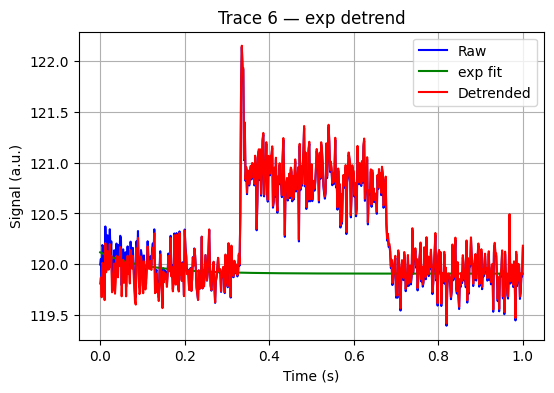

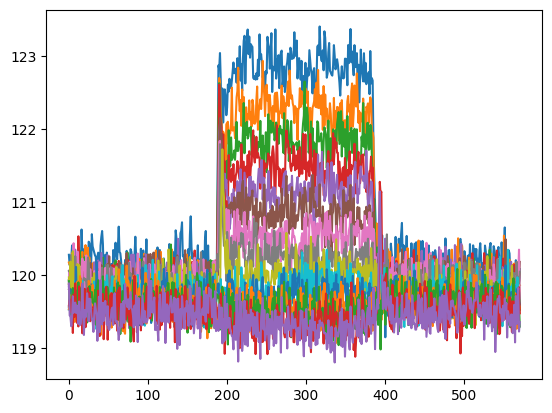

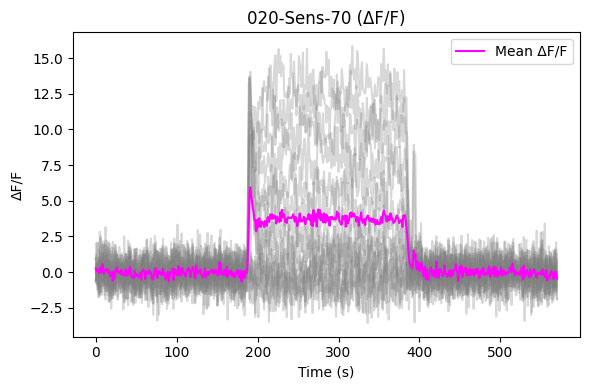

Metrics for 020-Sens-70_NDTiffStack.tif
{'Signal': array([ -97.3367,  -97.7171,  -98.0498, ..., -100.2056, -100.2057,
       -100.2291], shape=(15,)), 'Noise': array([0.2109, 0.2085, 0.1878, ..., 0.1592, 0.1906, 0.1773], shape=(15,)), 'Baseline_Cameracorr': array([20.2056, 19.9857, 19.8975, ..., 19.6755, 19.5356, 19.4989],
      shape=(15,)), 'dFF': array([-4.8173, -4.8894, -4.9277, ..., -5.0929, -5.1294, -5.1402],
      shape=(15,)), 'SNR': array([461.6084, 468.7097, 522.2029, ..., 629.4834, 525.6418, 565.2902],
      shape=(15,))}
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\sensitivity\020-Sens-70\020-Sens-70_denoised_full.tif
Loaded video: (15197, 89, 90)
Loaded mask: (89, 90)


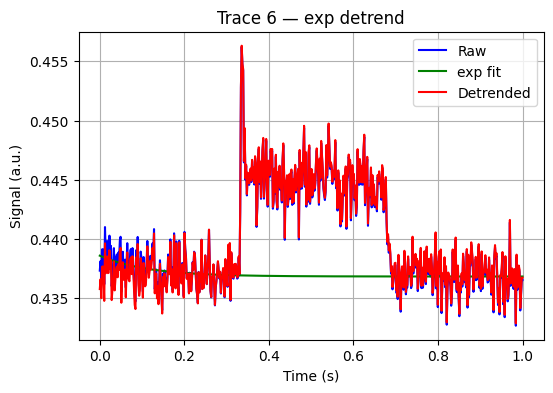

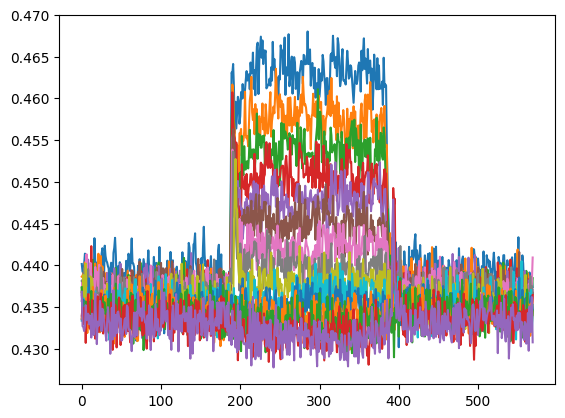

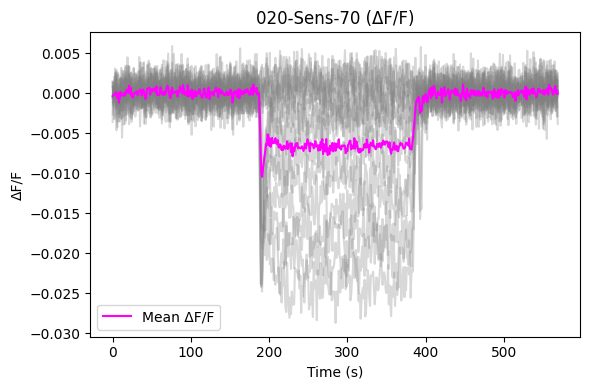

Metrics for 020-Sens-70_denoised_full.tif
{'Signal': array([ -99.9763,  -99.9798,  -99.9828, ..., -100.0018, -100.0019,
       -100.002 ], shape=(15,)), 'Noise': array([0.0019, 0.0018, 0.0016, ..., 0.0013, 0.0016, 0.0016], shape=(15,)), 'Baseline_Cameracorr': array([-99.5605, -99.5625, -99.5633, ..., -99.5653, -99.5664, -99.5667],
      shape=(15,)), 'dFF': array([1.0042, 1.0042, 1.0042, ..., 1.0044, 1.0044, 1.0044], shape=(15,)), 'SNR': array([53703.3853, 55066.7263, 62779.6028, ..., 74459.2622, 62295.1849,
       63765.6233], shape=(15,))}


In [ ]:
for vfile in sens_files:
    epochs = 15
    trace = extract_trace(vfile)
    mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=epochs, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=0)
    fluo = np.array(all_epochs).T
    
    baseline_mask = range(0, 50)
    mean_mask = range(200, 350)

    Yd, baselineFits, metrics = detrend_and_analyze(fluo, np.linspace(0, 1, fluo.shape[0]), fs=10, detrend_method="exp", baseline_mask=baseline_mask, mean_mask=mean_mask, index_test_trace=5)
    pd.DataFrame(metrics).to_csv(os.path.join(os.path.dirname(vfile), "metrics_sens.csv"))
    plt.plot(Yd)

    # --- compute ΔF/F per epoch ---
    baseline = np.nanmean(Yd[:50, :], axis=0, keepdims=True) - 100  # baseline per epoch
    signal = (Yd - baseline) - 100  # offset_camera=100
    dff = (signal / baseline) * 100  # ΔF/F in %

    # --- plot ΔF/F traces ---
    plt.figure(figsize=(6, 4))
    plt.plot(dff, color='gray', alpha=0.3)
    plt.plot(np.nanmean(dff, axis=1), color='magenta', lw=1.5, label='Mean ΔF/F')
    plt.title(f"{os.path.basename(os.path.dirname(vfile))} (ΔF/F)")
    plt.xlabel("Time (s)")
    plt.ylabel("ΔF/F")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Metrics for", os.path.basename(vfile))
    print(metrics)        


##### subthreshold files

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\033-Sub6mV-70-2x2\033-Sub6mV-70-2x2_NDTiffStack.tif
Loaded video: (19984, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\033-Sub6mV-70-2x2\033-Sub6mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


C:\Users\sofik\AppData\Local\Temp\ipykernel_14896\1064664.py:333: RuntimeWarning: overflow encountered in square
  return np.nansum(resid**2)


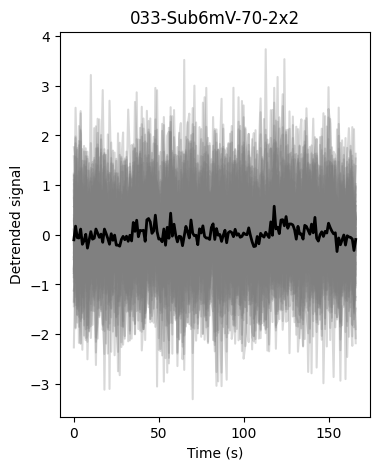

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-6mV-70-2x2\021-Sub-6mV-70-2x2_NDTiffStack.tif
Loaded video: (11408, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-6mV-70-2x2\021-Sub-6mV-70-2x2_NDTiffStack.tif
number of epochs detected: 28


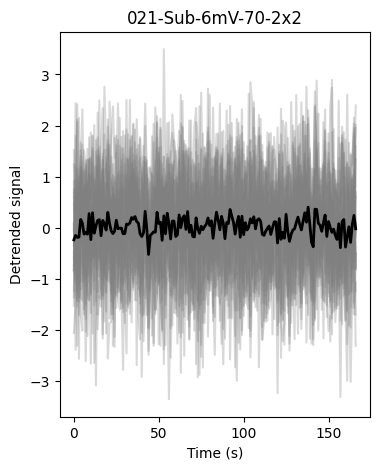

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-7mV-70-2x2\021-Sub-7mV-70-2x2_NDTiffStack.tif
Loaded video: (12906, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-7mV-70-2x2\021-Sub-7mV-70-2x2_NDTiffStack.tif
number of epochs detected: 32


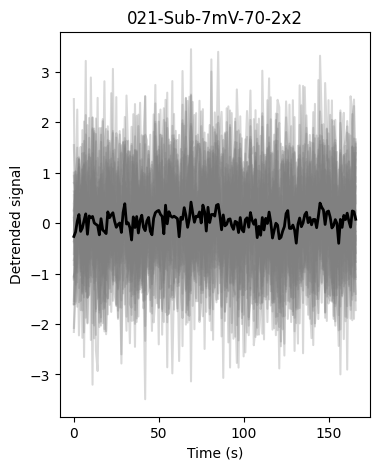

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-8mV-70-2x2\021-Sub-8mV-70-2x2_NDTiffStack.tif
Loaded video: (19986, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-8mV-70-2x2\021-Sub-8mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


C:\Users\sofik\AppData\Local\Temp\ipykernel_14896\1064664.py:298: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau) + b


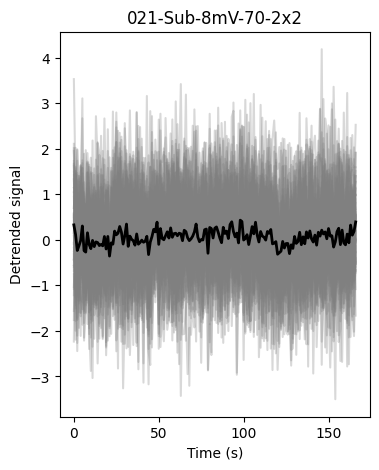

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-10mV-70-2x2\021-Sub-10mV-70-2x2_NDTiffStack.tif
Loaded video: (15190, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\021-Sub-10mV-70-2x2\021-Sub-10mV-70-2x2_NDTiffStack.tif
number of epochs detected: 38


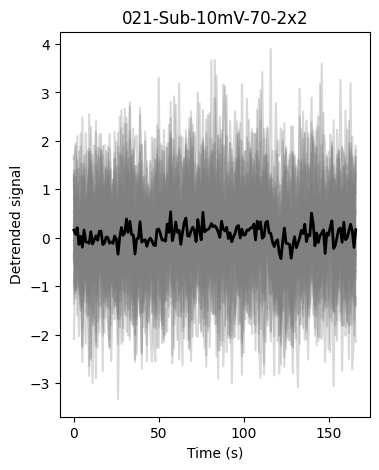

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\022-Sub-9mV-70-2x2\022-Sub-9mV-70-2x2_NDTiffStack.tif
Loaded video: (19992, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\022-Sub-9mV-70-2x2\022-Sub-9mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


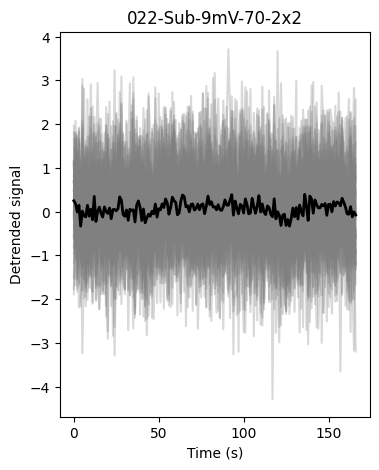

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\027-Sub-5mV-70-2x2\027-Sub-5mV-70-2x2_NDTiffStack.tif
Loaded video: (19989, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\027-Sub-5mV-70-2x2\027-Sub-5mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


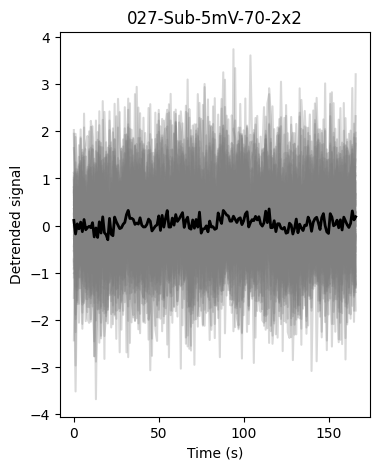

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\028-Sub-4mV-70-2x2\028-Sub-4mV-70-2x2_NDTiffStack.tif
Loaded video: (11800, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\028-Sub-4mV-70-2x2\028-Sub-4mV-70-2x2_NDTiffStack.tif
number of epochs detected: 29


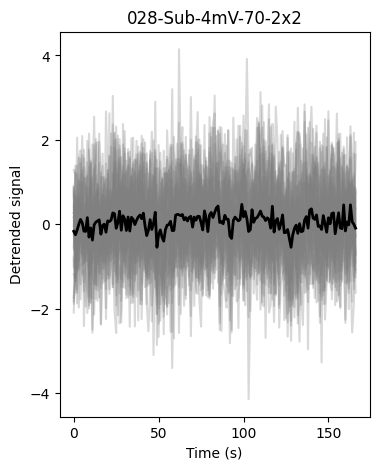

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\029-Sub-3mV-70-2x2\029-Sub-3mV-70-2x2_NDTiffStack.tif
Loaded video: (19989, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\029-Sub-3mV-70-2x2\029-Sub-3mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


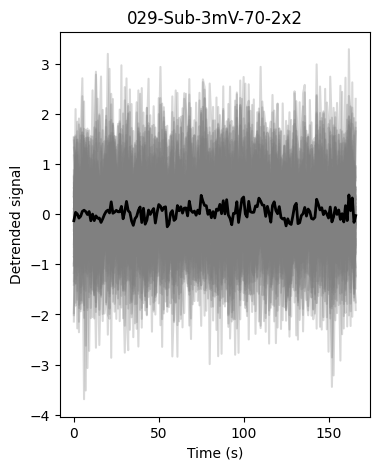

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\030-Sub3mV-70-2x2\030-Sub3mV-70-2x2_NDTiffStack.tif
Loaded video: (19991, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\030-Sub3mV-70-2x2\030-Sub3mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


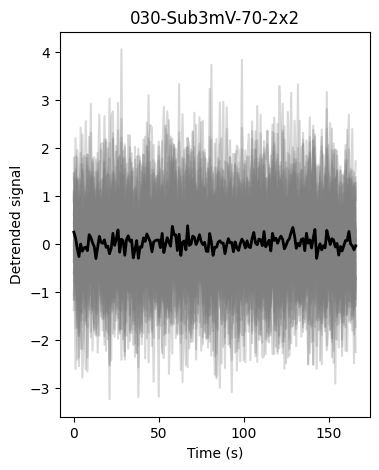

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\031-Sub4mV-70-2x2\031-Sub4mV-70-2x2_NDTiffStack.tif
Loaded video: (19991, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\031-Sub4mV-70-2x2\031-Sub4mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


C:\Users\sofik\AppData\Local\Temp\ipykernel_14896\1064664.py:298: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-t / tau) + b


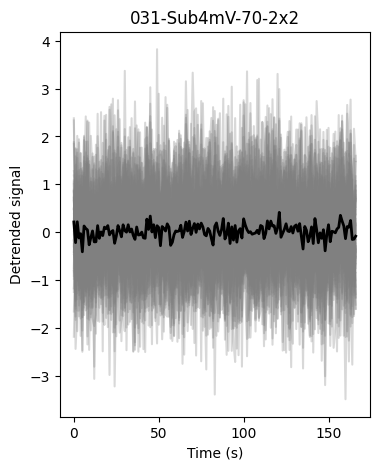

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\032-Sub5mV-70-2x2\032-Sub5mV-70-2x2_NDTiffStack.tif
Loaded video: (19989, 44, 45)
Loaded mask: (44, 45)
sub file to process E:\Paris2025\ForceB Undiluted\20251001\cell1\subthreshold\032-Sub5mV-70-2x2\032-Sub5mV-70-2x2_NDTiffStack.tif
number of epochs detected: 49


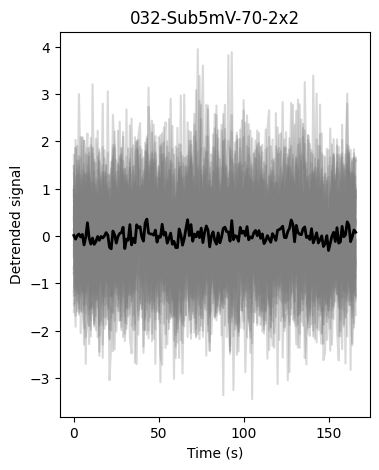

In [ ]:
for vfile in sub_files:
    file_to_n_epochs = {
        "033-Sub6mV-70-2x2": 50,
        "021-Sub-6mV-70-2x2": 29,
        "021-Sub-7mV-70-2x2": 33,
        "021-Sub-8mV-70-2x2": 50,
        "021-Sub-10mV-70-2x2": 39,
        "022-Sub-9mV-70-2x2": 50,
        "027-Sub-5mV-70-2x2": 50,
        "028-Sub-4mV-70-2x2": 30,
        "029-Sub-3mV-70-2x2": 50,
        "030-Sub3mV-70-2x2": 50,
        "031-Sub4mV-70-2x2": 50,
        "032-Sub5mV-70-2x2": 50,
    }
    epochs = file_to_n_epochs.get(os.path.basename(os.path.dirname(vfile)), 50)
    trace = extract_trace(vfile)
    print("sub file to process", vfile)
    mean_epoch, all_epochs = detect_epochs_and_average(
        trace,
        n_epochs=epochs,
        light_on_off_buffer_nframes=light_on_off_buffer_nframes,
        skip_first=1
    )
    print("number of epochs detected:", len(all_epochs))
    
    fluo = np.array(all_epochs).T  
    Yd, baselineFits, metrics = detrend_and_analyze(
        fluo,
        np.linspace(0, 1, fluo.shape[0]),
        fs=10,
        detrend_method="exp",
        baseline_mask=range(0, 30),
        mean_mask=range(120, 130)
    )
    plt.figure(figsize=(4,5))
        # --- compute ΔF/F per epoch ---
    baseline = np.nanmean(Yd[:50, :], axis=0, keepdims=True) - 100  # baseline per epoch
    signal = (Yd - baseline) - 100  # offset_camera=100
    dff = (signal / baseline) * 100  # ΔF/F in %
    plt.plot(dff, alpha=0.3, color='gray')
    plt.plot(np.mean(dff, axis=1), 'k', linewidth=2)
    plt.title(os.path.basename(os.path.dirname(vfile)))
    plt.xlabel("Time (s)")
    plt.ylabel("Detrended signal")
    plt.show()


## Sensitivity Curve (one file)

functions_path: E:/Paris2025/Ephys/011025


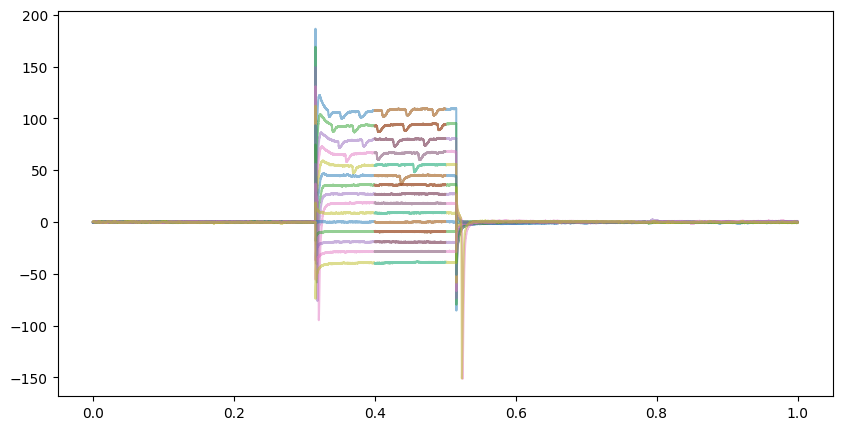

In [64]:
ephys_day_folder = r"E:/Paris2025/Ephys/011025"
print("functions_path:", ephys_day_folder)
sys.path.append(ephys_day_folder)
IVlist = [f for f in os.listdir(ephys_day_folder) if os.path.isfile(os.path.join(ephys_day_folder, f)) and f.endswith('.abf')]
IVlist = IVlist[20:21]

# Initialize lists to store data
all_currents = []
all_voltages = []
folder_name = os.path.basename(os.path.dirname(ephys_day_folder))

plt.figure(figsize=(10, 5))

# Loop through each file
for file_path in IVlist:
    file_path = os.path.join(ephys_day_folder, file_path)
    abf = pyabf.ABF(file_path)
    # Set the time points of interest
    pt1 = int(400 * abf.dataPointsPerMs)  # Time point after step onset for steady-state current
    pt2 = int(500 * abf.dataPointsPerMs)
    
    # Initialize lists for current and voltage data of current file
    currents = []
    voltages = []
    # Loop through each sweep in the current file
    for sweep in abf.sweepList: #[0:8]:
        abf.setSweep(sweep, baseline=[0, 0.12])
        sweepY= abf.sweepY/20
        # Calculate voltage and steady-state current
        avg_voltage = np.average(sweepY[pt1:pt2])
        voltages.append(avg_voltage)
        steady_state_current = abf.sweepEpochs.levels[2]
        currents.append(steady_state_current)
        
        plt.plot(abf.sweepX, sweepY, alpha=.5, label=f"sweep {sweep}")
        plt.plot(abf.sweepX[pt1:pt2], sweepY[pt1:pt2], alpha=.5, label=f"sweep {sweep}")
    plt.show()

    # Append current and voltage data of current file to the overall lists
    all_currents.append(currents)
    all_voltages.append(voltages)
    

Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\sensitivity\020-Sens-70\020-Sens-70_NDTiffStack.tif
Loaded video: (15197, 89, 90)
Loaded mask: (89, 90)


<Figure size 800x500 with 0 Axes>

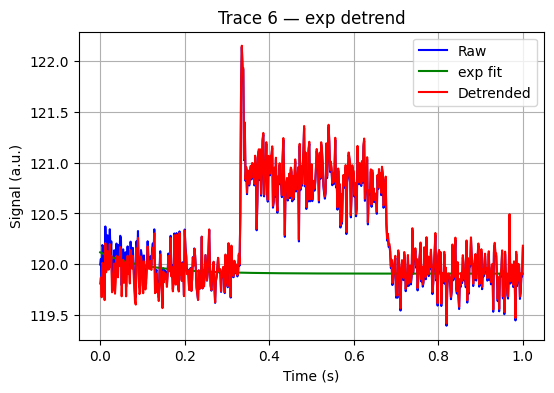

[[ 0.4744  1.015   0.2482 ...  1.5035  0.2824  2.0663]
 [-0.2339  0.8581 -0.5533 ...  0.1625  0.6853 -0.1728]
 [-0.053   0.8408 -0.1754 ... -0.0336 -0.1868 -0.2775]
 ...
 [-0.7697 -0.2018  0.3359 ... -0.707   0.4324  1.749 ]
 [-1.005  -0.4644  1.033  ... -0.1891  1.5547 -1.3066]
 [-0.4977 -0.545  -1.7981 ... -1.6647 -0.2632 -0.6383]]
Loading video from: E:\Paris2025\ForceB Undiluted\20251001\cell1\sensitivity\020-Sens-70\020-Sens-70_denoised_full.tif
Loaded video: (15197, 89, 90)
Loaded mask: (89, 90)


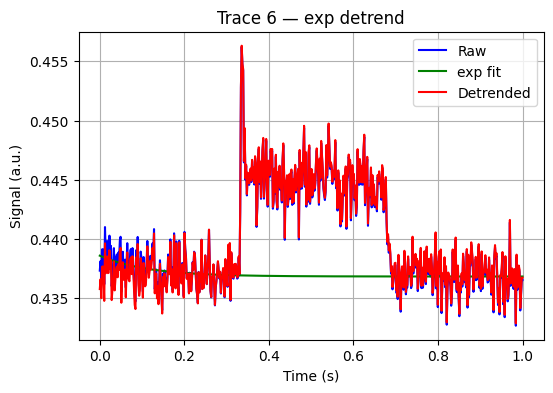

[[-0.0009 -0.0013 -0.0007 ... -0.0031 -0.0004 -0.0037]
 [ 0.0001 -0.0014  0.0007 ... -0.0003 -0.0014  0.0004]
 [ 0.0002 -0.0017  0.0002 ...  0.0002  0.0006  0.0005]
 ...
 [ 0.0013  0.0004  0.     ... -0.0007  0.0014 -0.0013]
 [ 0.0011  0.0007 -0.0002 ...  0.0014 -0.0009 -0.0031]
 [ 0.0019  0.0007 -0.0018 ... -0.0003 -0.0029  0.0024]]
Average fluorescence over epochs: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


C:\Users\sofik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sofik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


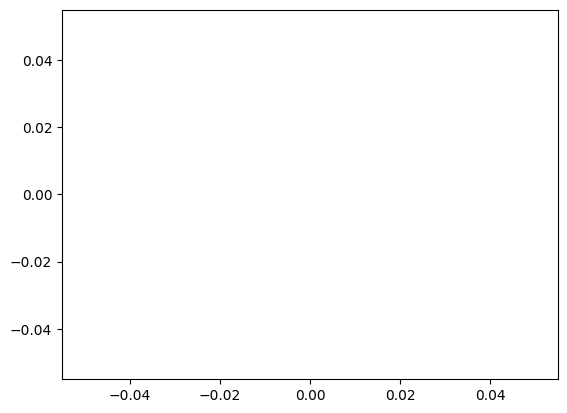

x (Voltage): [ 52.6102  37.9042  24.236  ... -74.3159 -83.3575 -94.046 ]
y (Fluorescence): [nan nan nan ... nan nan nan]
any nans in x? False any nans in y? True


ValueError: array must not contain infs or NaNs

In [75]:
plt.figure(figsize=(8, 5))
dff_list = []
for vfile in sens_files:
    epochs = 15
    trace = extract_trace(vfile)
    mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=epochs, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=0)
    fluo = np.array(all_epochs).T

    baseline_mask = range(0, 100)
    mean_mask = range(200, 400)

    Yd, baselineFits, metrics = detrend_and_analyze(fluo, np.linspace(0, 1, fluo.shape[0]), fs=10, detrend_method="exp", baseline_mask=baseline_mask, mean_mask=mean_mask, index_test_trace=5)

    # --- compute ΔF/F per epoch ---
    baseline = np.nanmean(Yd[baseline_mask, :], axis=0, keepdims=True) - 100  # baseline per epoch
    signal = (Yd - baseline) - 100  # offset_camera=100
    dff = (signal / baseline) * 100  # ΔF/F in %
    print(dff)
    dff_list.append(np.mean(dff, axis=0))
     
start = 200
end = 300
dff_list = np.array(dff_list)   # convert to NumPy array
avgFl = []
for i in range(dff_list.shape[1]):  # iterate over epochs (columns)
    plt.plot(dff_list[start:end, i], lw=1, alpha=0.8)
    avg_fluo = np.mean(dff_list[start:end, i])
    avgFl.append(avg_fluo)
print("Average fluorescence over epochs:", avgFl)
plt.show()

holding = -55

x = np.array(voltages) + holding  # your x-axis
y = np.array(avgFl)     # your y-axis
print("x (Voltage):", x)
print("y (Fluorescence):", y)
print("any nans in x?", np.isnan(x).any(), "any nans in y?", np.isnan(y).any())

p0 = [max(y)-min(y), np.median(x), 1, min(y)]
popt, pcov = curve_fit(sigmoid, x, y, p0, method='dogbox')

# Plot original and fitted
x_fit = np.linspace(min(x), max(x), 500)
y_fit = sigmoid(x_fit, *popt) 

plt.figure(figsize=(8,5))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_fit, y_fit, '-', label='Sigmoid fit')
plt.xlabel('Voltage')
plt.ylabel('Fluorescence')
plt.legend()
plt.show()

In [69]:
print(dff_list)

[[ 4.475   3.919   3.3789 ... -0.4704 -0.3048 -0.3506]
 [-0.0081 -0.0069 -0.006  ...  0.0008  0.0006  0.0006]]


### detrend one file with rolling window + bad zscore

In [ ]:
light_on_off_buffer_nframes = 10

sens_files = [f for f in video_files if "Sens" in os.path.basename(os.path.dirname(f))]
traces = []
fluo = []
epochs = 15
if sens_files:
    trace = extract_trace(sens_files[0])
    print("sens file to process", sens_files[0])
    mean_epoch, all_epochs = detect_epochs_and_average(trace, n_epochs=epochs, light_on_off_buffer_nframes=light_on_off_buffer_nframes, skip_first=0)
    fluo.append(all_epochs)
    
fluo = np.squeeze(fluo).T

x = np.linspace(0, len(fluo)-1, len(fluo))
fluofit = fluo.copy().astype(float)
# Mask unwanted region
fluofit[180:400, 1] = np.nan

# Interpolate over NaNs to create a continuous baseline for smoothing
valid = np.isfinite(fluofit[:, 1])
interp = np.interp(x, x[valid], fluofit[valid, 1])

# Smooth interpolated baseline
smoothed = uniform_filter1d(interp, size=20)  # increase size for smoother trend

# Detrend but keep same baseline level
baseline_level = np.nanmedian(fluofit[:, 1])
detrended = (fluo[:, 1] - smoothed) + baseline_level

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fluo[:, 1], label='Original')
plt.plot(smoothed, label='Smoothed baseline', color='red')
plt.plot(detrended, label='Detrended', color='green')
plt.axhline(baseline_level, color='gray', linestyle='--', label='Baseline')
plt.legend()
plt.show()


#loop over raws
zsc = zscore(fluo[:, 1], axis=0, ddof=0)
zsc
plt.plot(zsc)
plt.show()